<a href="https://colab.research.google.com/github/FlyAIBox/langchain-academy/blob/fly101/module-2/chatbot-summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 带消息摘要功能的聊天机器人

## 回顾

我们已经学习了如何自定义图状态模式（graph state schema）和状态归约器（reducer）。

我们也展示了多种在图状态中修剪或过滤消息的方法。

## 目标

现在，让我们更进一步！

不仅仅是修剪或过滤消息，我们将展示如何使用大语言模型（LLM）来生成对话的持续摘要。

这使我们能够保留完整对话的压缩表示，而不是简单地通过修剪或过滤来删除它们。

我们将把这种摘要功能整合到一个简单的聊天机器人中。

并且我们将为这个聊天机器人配备记忆功能，支持长时间运行的对话，而不会产生高昂的token成本或延迟。

In [1]:
# 安装必要的依赖包
# 使用 %%capture 来隐藏安装过程的输出信息
%%capture --no-stderr
# %pip install --quiet -U langchain_core langgraph langchain_openai
%pip install --quiet langchain_openai==0.3.32 langchain_core==0.3.75 langgraph==0.6.7

In [2]:
import os, getpass

def _set_env(var: str):
    """
    设置环境变量的辅助函数
    如果环境变量不存在，则提示用户输入
    """
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# 设置 OpenAI API 密钥
# 这是使用 OpenAI 模型所必需的
_set_env("OPENAI_API_KEY")
# 设置 OpenAI API代理地址 (例如：https://api.apiyi.com/v1）
_set_env("OPENAI_BASE_URL")

OPENAI_API_KEY: ··········
OPENAI_BASE_URL: ··········


我们将使用 [LangSmith](https://docs.smith.langchain.com/) 进行[追踪](https://docs.smith.langchain.com/concepts/tracing)。

LangSmith 是 LangChain 提供的调试和监控工具，可以帮助我们：
- 追踪 LLM 调用链
- 监控性能和成本
- 调试对话流程
- 分析模型行为

In [3]:
# 设置 LangSmith 相关环境变量
# LangSmith 用于追踪和调试 LangChain 应用
_set_env("LANGSMITH_API_KEY")  # LangSmith API 密钥
os.environ["LANGSMITH_TRACING"] = "true"  # 启用追踪功能
os.environ["LANGSMITH_PROJECT"] = "FlyAIBox"  # 设置项目名称

LANGSMITH_API_KEY: ··········


In [4]:
from langchain_openai import ChatOpenAI

# 初始化 OpenAI 聊天模型
# gpt-4o: 使用 GPT-4 Omni 模型，这是 OpenAI 最新的多模态模型
# temperature=0: 设置温度为 0，使模型输出更加确定性和一致
model = ChatOpenAI(model="gpt-4o", temperature=0)

我们将使用 `MessagesState`，就像之前一样。

除了内置的 `messages` 键之外，我们现在还将包含一个自定义键（`summary`）。

**状态设计说明：**
- `messages`: 存储对话历史消息列表
- `summary`: 存储对话的摘要信息，用于压缩长对话历史

In [5]:
from langgraph.graph import MessagesState

class State(MessagesState):
    """
    自定义状态类，继承自 MessagesState

    继承的功能：
    - messages: 消息列表，用于存储对话历史

    新增功能：
    - summary: 字符串类型，用于存储对话摘要
    """
    summary: str

我们将定义一个节点来调用我们的 LLM，如果存在摘要，则将其融入到提示中。

**节点功能说明：**
- 检查状态中是否存在摘要
- 如果存在摘要，将其作为系统消息添加到对话中
- 调用 LLM 生成回复
- 返回 AI 的回复消息

In [6]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

def call_model(state: State):
    """
    调用 LLM 模型生成回复的节点函数

    参数:
        state (State): 当前图状态，包含消息和摘要信息

    返回:
        dict: 包含 AI 回复消息的字典

    功能说明:
        1. 检查状态中是否存在对话摘要
        2. 如果存在摘要，将其作为系统消息添加到对话上下文中
        3. 调用 LLM 模型生成回复
        4. 返回包含 AI 回复的状态更新
    """

    # 获取摘要信息，如果不存在则返回空字符串
    summary = state.get("summary", "")

    # 如果存在摘要，将其融入到提示中
    if summary:
        # 创建包含摘要的系统消息
        # 这有助于 LLM 理解之前的对话上下文
        # system_message = f"Summary of conversation earlier: {summary}"
        system_message = f"此前对话的摘要：{summary}"

        # 将系统消息添加到消息列表的开头
        # 系统消息通常用于提供上下文和指令
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        # 如果没有摘要，直接使用原始消息
        messages = state["messages"]

    # 调用 LLM 模型生成回复
    response = model.invoke(messages)

    # 返回包含新消息的状态更新
    return {"messages": response}

我们将定义一个节点来生成摘要。

**摘要节点功能：**
- 分析当前对话历史
- 使用 LLM 生成对话摘要
- 清理旧消息，只保留最近的几条消息
- 更新状态中的摘要信息

**注意：** 这里我们将使用 `RemoveMessage` 在生成摘要后过滤我们的状态，这样可以：
- 减少内存占用
- 降低后续调用的 token 成本
- 保持对话的连续性

In [7]:
def summarize_conversation(state: State):
    """
    生成对话摘要的节点函数

    参数:
        state (State): 当前图状态，包含消息和摘要信息

    返回:
        dict: 包含新摘要和消息删除指令的字典

    功能说明:
        1. 检查是否已存在摘要
        2. 根据情况创建不同的摘要提示
        3. 调用 LLM 生成或更新摘要
        4. 删除旧消息，只保留最近的 2 条消息
        5. 更新状态中的摘要信息
    """

    # 首先获取任何现有的摘要
    summary = state.get("summary", "")

    # 创建摘要提示
    # if summary:
    #     # 如果摘要已存在，则扩展现有摘要
    #     summary_message = (
    #         f"This is summary of the conversation to date: {summary}\n\n"
    #         "Extend the summary by taking into account the new messages above:"
    #     )

    # else:
    #     # 如果没有现有摘要，则创建新摘要
    #     summary_message = "Create a summary of the conversation above:"

    if summary:
      # 如果摘要已存在，则扩展现有摘要
      summary_message = (
          f"目前为止的对话摘要：{summary}\n\n"
          "请结合上方的新消息，扩展现有摘要："
      )

    else:
        # 如果没有现有摘要，则创建新摘要
        summary_message = "请对上方的对话创建摘要："

    # 将摘要提示添加到消息历史中
    # 这样 LLM 可以基于完整的对话历史生成摘要
    messages = state["messages"] + [HumanMessage(content=summary_message)]

    # 调用 LLM 生成摘要
    response = model.invoke(messages)

    # 删除除最近 2 条消息外的所有消息
    # 这样可以减少内存占用和 token 成本
    # RemoveMessage 用于标记消息为删除状态
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    # 返回新的摘要和消息删除指令
    return {"summary": response.content, "messages": delete_messages}

我们将添加一个条件边来决定是否基于对话长度生成摘要。

**条件边的作用：**
- 监控对话中的消息数量
- 当消息数量超过阈值时，触发摘要生成
- 否则直接结束对话
- 这样可以平衡对话质量和性能

In [8]:
from langgraph.graph import END
from typing_extensions import Literal

def should_continue(state: State) -> Literal["summarize_conversation", END]:
    """
    决定是否继续对话或生成摘要的条件函数

    参数:
        state (State): 当前图状态

    返回:
        Literal: 下一个要执行的节点名称或 END

    功能说明:
        根据对话中的消息数量决定下一步操作：
        - 如果消息数量 > 6，则生成摘要
        - 否则直接结束对话

    设计理念:
        这个阈值可以根据实际需求调整：
        - 较小的阈值：更频繁的摘要，但可能丢失细节
        - 较大的阈值：保留更多上下文，但可能增加成本
    """

    messages = state["messages"]

    # 如果消息数量超过 6 条，则生成对话摘要
    # 这个阈值可以根据实际需求调整
    if len(messages) > 6:
        return "summarize_conversation"

    # 否则直接结束对话
    return END

## 添加记忆功能

回顾一下，[状态在单次图执行中是瞬态的](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220)。

这限制了我们在中断情况下进行多轮对话的能力。

正如在模块 1 末尾介绍的那样，我们可以使用[持久化](https://langchain-ai.github.io/langgraph/how-tos/persistence/)来解决这个问题！

**LangGraph 持久化机制：**
- LangGraph 可以使用检查点器（checkpointer）在每一步后自动保存图状态
- 这个内置的持久化层为我们提供了记忆功能
- 允许 LangGraph 从最后一次状态更新处继续执行

**MemorySaver 介绍：**
- 我们之前展示的最容易使用的检查点器之一是 `MemorySaver`
- 它是一个用于图状态的内存键值存储
- 我们只需要在编译图时添加检查点器，图就具有了记忆功能！

**记忆功能的好处：**
- 支持长时间运行的对话
- 可以在中断后恢复对话
- 保持对话的连续性和上下文

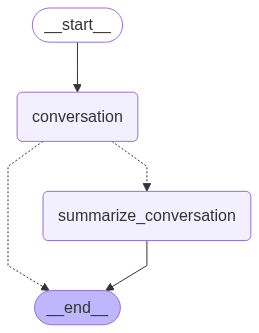

In [9]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# 定义一个新的图工作流
workflow = StateGraph(State)

# 添加节点
# conversation: 处理用户输入并生成回复的节点
workflow.add_node("conversation", call_model)
# summarize_conversation: 生成对话摘要的节点
workflow.add_node(summarize_conversation)

# 设置图的连接关系
# 设置入口点为 conversation 节点
workflow.add_edge(START, "conversation")
# 添加条件边：根据消息数量决定是否生成摘要
workflow.add_conditional_edges("conversation", should_continue)
# 摘要生成完成后直接结束
workflow.add_edge("summarize_conversation", END)

# 编译图并添加记忆功能
memory = MemorySaver()  # 创建内存检查点器
graph = workflow.compile(checkpointer=memory)  # 编译图并启用持久化

# 显示图的流程图
# 这有助于理解整个对话流程
display(Image(graph.get_graph().draw_mermaid_png()))

## 线程（Threads）

检查点器在每一步都将状态保存为检查点。

这些保存的检查点可以分组到一个对话的`线程`中。

**线程概念类比：**
- 想象 Slack 作为类比：不同的频道承载不同的对话
- 线程就像 Slack 频道，捕获分组的状态集合（例如对话）

**线程的作用：**
- 隔离不同的对话会话
- 允许同时进行多个独立的对话
- 每个线程维护自己的状态和记忆

**配置线程：**
- 使用 `configurable` 参数设置线程 ID
- 不同的线程 ID 对应不同的对话会话
- 这样可以在同一个图中管理多个独立的对话

![状态图](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbadf3b379c2ee621adfd1_chatbot-summarization1.png)

In [10]:
# 创建一个对话线程
# 线程 ID 用于区分不同的对话会话
config = {"configurable": {"thread_id": "1"}}

# 开始对话 - 第一轮
print("=== 第一轮对话 ===")
input_message = HumanMessage(content="你好！我是Lance")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

# 继续对话 - 第二轮
print("\n=== 第二轮对话 ===")
input_message = HumanMessage(content="我叫什么名字？")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

# 继续对话 - 第三轮
print("\n=== 第三轮对话 ===")
input_message = HumanMessage(content="我喜欢YoYoMA的古典音乐")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

# 注意：由于我们使用了相同的 config（相同的线程 ID），
# 聊天机器人可以记住之前的对话内容

=== 第一轮对话 ===
================================== Ai Message ==================================

你好，Lance！很高兴见到你。有什么我可以帮助你的吗？

=== 第二轮对话 ===


================================== Ai Message ==================================

你告诉我你叫Lance。有什么我可以帮助你的吗？

=== 第三轮对话 ===


================================== Ai Message ==================================

Yo-Yo Ma是一位非常杰出的古典大提琴家，他的音乐作品深受许多人喜爱。他以其丰富的情感表达和精湛的技艺而闻名。你有特别喜欢他的哪一部作品或专辑吗？


现在，我们还没有生成状态摘要，因为我们仍然有 ≤ 6 条消息。

这是在 `should_continue` 函数中设置的。

```python
# 如果消息数量超过 6 条，则生成对话摘要
if len(messages) > 6:
    return "summarize_conversation"
```

**当前状态分析：**
- 目前有 6 条消息（3 轮对话，每轮 2 条消息）
- 还没有达到触发摘要的阈值（> 6）
- 因此对话直接结束，没有生成摘要

**线程的作用：**
- 由于我们使用了线程，可以继续对话
- 每次调用都会从上次的状态继续
- 这展示了记忆功能的重要性

In [15]:
# 检查当前线程的状态摘要
# 由于消息数量还没有超过阈值，摘要应该为空
current_summary = graph.get_state(config).values.get("summary", "")
print(f"当前摘要: '{current_summary}'")
print("说明: 由于消息数量 ≤ 6，还没有生成摘要")

当前摘要: '在这段对话中，用户自我介绍为Lance，并表示喜欢Yo-Yo Ma的古典音乐和乒乓球运动员孙颖莎。用户提到孙颖莎是否是乒乓球女单世界第一，并对她的表现表示认可。'
说明: 由于消息数量 ≤ 6，还没有生成摘要


带有线程 ID 的 `config` 允许我们从之前记录的状态继续！

**线程记忆功能演示：**
- 每次调用 `graph.invoke()` 时都使用相同的 `config`
- 这确保了对话的连续性和上下文保持
- 聊天机器人能够记住之前的所有对话内容

In [12]:
# 继续对话 - 第四轮（这将触发摘要生成）
print("=== 第四轮对话（触发摘要） ===")
input_message = (HumanMessage(content="我喜欢孙颖莎，她不是乒乓球女单世界第一吗？"))
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

# 注意：这一轮对话后，消息数量将超过 6 条
# 系统会自动生成对话摘要

=== 第四轮对话（触发摘要） ===


================================== Ai Message ==================================

孙颖莎是一位非常优秀的乒乓球运动员，她在国际比赛中取得了许多优异的成绩。不过，乒乓球世界排名会根据选手在各项赛事中的表现进行动态调整，因此她是否是当前的世界第一需要查看最新的排名更新。无论如何，她的实力和表现都得到了广泛的认可。你喜欢她的比赛风格吗？


In [13]:
# 检查摘要生成后的状态
# 现在应该有了对话摘要
final_summary = graph.get_state(config).values.get("summary", "")
print("=== 生成的对话摘要 ===")
print(f"摘要内容: {final_summary}")
print("\n=== 摘要功能说明 ===")
print("1. 系统自动分析了整个对话历史")
print("2. 生成了包含关键信息的摘要")
print("3. 旧消息被清理，只保留最近的 2 条")
print("4. 摘要将在后续对话中提供上下文")

=== 生成的对话摘要 ===
摘要内容: 在这段对话中，用户自我介绍为Lance，并表示喜欢Yo-Yo Ma的古典音乐和乒乓球运动员孙颖莎。用户提到孙颖莎是否是乒乓球女单世界第一，并对她的表现表示认可。

=== 摘要功能说明 ===
1. 系统自动分析了整个对话历史
2. 生成了包含关键信息的摘要
3. 旧消息被清理，只保留最近的 2 条
4. 摘要将在后续对话中提供上下文


## LangSmith 追踪

让我们查看追踪信息！

**LangSmith 追踪功能：**
- 可以查看完整的对话流程
- 监控每个节点的执行情况
- 分析 LLM 调用的性能和成本
- 调试对话逻辑和状态变化

**如何查看追踪：**
1. 访问 LangSmith 网站
2. 登录您的账户
3. 查看 "FlyAIBox" 项目
4. 找到最新的追踪记录
5. 分析对话流程和性能指标

## 系统架构总结

### 核心组件

1. **状态管理 (State)**
   - `MessagesState`: 基础消息状态
   - `summary`: 自定义摘要字段
   - 支持消息的增删改查

2. **节点功能 (Nodes)**
   - `call_model`: 调用 LLM 生成回复
   - `summarize_conversation`: 生成对话摘要
   - `should_continue`: 条件判断逻辑

3. **记忆系统 (Memory)**
   - `MemorySaver`: 内存检查点器
   - 线程隔离: 支持多对话并行
   - 状态持久化: 支持中断恢复

### 工作流程

```
用户输入 → call_model → should_continue →
    ↓                    ↓
   结束               summarize_conversation → 结束
```

### 关键特性

- **智能摘要**: 自动压缩长对话历史
- **记忆保持**: 支持长时间对话
- **成本优化**: 减少 token 使用量
- **状态管理**: 灵活的状态更新机制

### 适用场景

- 客服聊天机器人
- 个人助手应用
- 教育对话系统
- 技术支持工具


In [14]:
# 演示如何创建新的对话线程
print("=== 创建新对话线程演示 ===")

# 创建新的线程配置
new_config = {"configurable": {"thread_id": "2"}}

# 在新线程中开始对话
print("新线程中的对话：")
input_message = HumanMessage(content="你好，我是新用户")
output = graph.invoke({"messages": [input_message]}, new_config)
for m in output['messages'][-1:]:
    m.pretty_print()

print("\n=== 线程隔离说明 ===")
print("1. 线程 1 和线程 2 是完全独立的对话")
print("2. 每个线程维护自己的状态和记忆")
print("3. 可以在同一个图中同时管理多个对话")
print("4. 这类似于 Slack 中的不同频道")


=== 创建新对话线程演示 ===
新线程中的对话：


================================== Ai Message ==================================

你好！欢迎你！如果你有任何问题或者需要帮助，请随时告诉我。有什么我可以为你做的吗？

=== 线程隔离说明 ===
1. 线程 1 和线程 2 是完全独立的对话
2. 每个线程维护自己的状态和记忆
3. 可以在同一个图中同时管理多个对话
4. 这类似于 Slack 中的不同频道
